In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf
import umap
import warnings

from dirichlet import mle
from scipy.special import rel_entr
from scipy.stats import dirichlet
from sklearn.manifold import TSNE
from src.models.synthesis.wgan.utils import CustomHistory
from src.models.synthesis.wgan.critics import MLPCritic
from src.models.synthesis.wgan.generators import MLPGenerator
from src.models.synthesis.wgan.wgan import WGANGP, critic_loss, generator_loss


warnings.filterwarnings("ignore")
np.set_printoptions(suppress=True)

tf.__version__

'2.16.1'

# Dirichlet samples

In [2]:
train_data_path = os.path.join("data", "processed", "experimental", "synthesis", "train*1*")

for filename in glob.glob(train_data_path):
    df = pd.read_csv(filename)
    compositions = df.iloc[:, df.columns.str.contains("z")].drop_duplicates() / 100.0
    alpha = mle(compositions)
    break

print(alpha)
compositions

[ 0.60014617  0.96564818 40.29585531  4.02038511  2.45830013  0.82835144
  1.3209936   0.72348203  0.89781807  1.21861795  1.40969686  1.88019475
  1.72151252  1.70727229  1.65794152  1.64343775  1.75448398  1.65347209
  1.62687721  1.36147134  1.23703022  1.22615379  1.102848   12.79669992]


,zN2,zCO2,zC1,zC2,zC3,zIC4,zNC4,zIC5,zNC5,zC6,...,zC11,zC12,zC13,zC14,zC15,zC16,zC17,zC18,zC19,zC20
0,0.0038,0.1059,0.4755,0.0723,0.0477,0.0082,0.0208,0.0069,0.0108,0.0136,...,0.0108,0.0098,0.0100,0.0084,0.0079,0.0063,0.0052,0.0059,0.0053,0.0961
1,0.0043,0.1055,0.4763,0.0685,0.0472,0.0082,0.0209,0.0076,0.0125,0.0154,...,0.0110,0.0101,0.0103,0.0117,0.0085,0.0086,0.0060,0.0070,0.0054,0.0851
2,0.0005,0.0044,0.4967,0.0272,0.0063,0.0013,0.0030,0.0007,0.0010,0.0066,...,0.0222,0.0256,0.0210,0.0228,0.0231,0.0197,0.0168,0.0156,0.0124,0.2022
3,0.0007,0.0190,0.4934,0.0281,0.0066,0.0016,0.0034,0.0011,0.0015,0.0028,...,0.0155,0.0202,0.0172,0.0208,0.0184,0.0181,0.0151,0.0146,0.0170,0.2406
4,0.0051,0.0001,0.4263,0.0673,0.0540,0.0083,0.0231,0.0083,0.0133,0.0192,...,0.0217,0.0218,0.0195,0.0163,0.0157,0.0119,0.0132,0.0128,0.0052,0.1208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,0.0024,0.0006,0.4214,0.0236,0.0076,0.0035,0.0042,0.0028,0.0022,0.0040,...,0.0118,0.0112,0.0151,0.0173,0.0179,0.0131,0.0172,0.0144,0.0134,0.3544
273,0.0011,0.0003,0.4808,0.0097,0.0015,0.0002,0.0005,0.0008,0.0005,0.0006,...,0.0048,0.0083,0.0113,0.0127,0.0142,0.0093,0.0139,0.0122,0.0071,0.4068
274,0.0030,0.0009,0.4019,0.0230,0.0075,0.0034,0.0041,0.0027,0.0021,0.0039,...,0.0100,0.0097,0.0121,0.0143,0.0146,0.0108,0.0145,0.0156,0.0092,0.3993
275,0.0041,0.0250,0.6111,0.0635,0.0428,0.0084,0.0175,0.0060,0.0095,0.0132,...,0.0112,0.0097,0.0102,0.0087,0.0082,0.0061,0.0053,0.0051,0.0049,0.0683


# Wasserstein GAN samples

In [4]:
# Training WGAN
latent_dim = 16
lambda_ = 10.0
n_critic = 5
lr = 0.0001
beta_1, beta_2 = 0.5, 0.9
batch_size = 32
epochs = 3000

output_dim = compositions.shape[-1]

print(f"samples, features: {compositions.values.shape}", end="\n\n")
data = compositions.values.astype(np.float32)
dataset = tf.data.Dataset.from_tensor_slices(data)
dataset = dataset.batch(batch_size)

critic = MLPCritic(hidden_units=[512, 512, 512])
generator = MLPGenerator(output_dim=output_dim, hidden_units=[512, 512, 512])

critic_optimizer = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=beta_1, beta_2=beta_2)
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=beta_1, beta_2=beta_2)

# Get the Wasserstein GAN model
wgan = WGANGP(critic=critic, generator=generator, latent_dim=latent_dim, n_critic=n_critic, lambda_=lambda_)

# Compile the Wasserstein GAN model
wgan.compile(
    critic_optimizer=critic_optimizer,
    generator_optimizer=generator_optimizer,
    critic_loss_fn=critic_loss,
    generator_loss_fn=generator_loss,
)

callbacks = [CustomHistory()]
wgan.fit(dataset, epochs=epochs, callbacks=callbacks)

critic.save("notebooks\\models\\critic_model.keras")
generator.save("notebooks\\models\\generator_model.keras")

neg_critic_loss = -np.array(callbacks[0].history["critic_loss"])
batches = neg_critic_loss.shape[0]

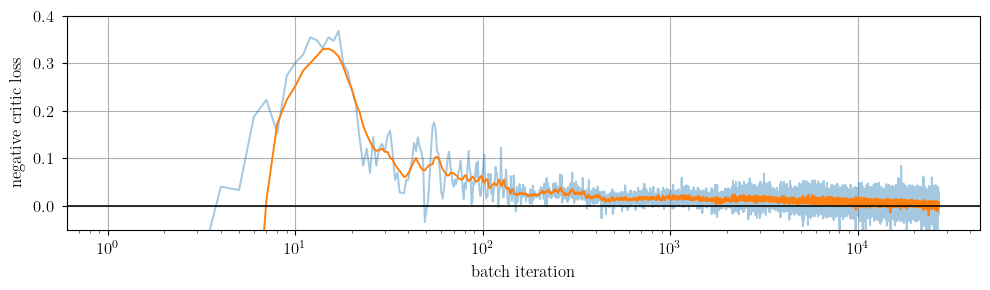

In [5]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(np.arange(batches), neg_critic_loss, alpha=0.4)
ax.plot(np.arange(batches), pd.Series(neg_critic_loss).rolling(10, center=True).mean())
ax.set_xlabel("batch iteration")
ax.set_ylabel("negative critic loss")
ax.set_ylim([-0.05, 0.4])
ax.axhline(y=0.0, color=("black", 0.8), linestyle="-")
ax.grid()

# ax.set_yscale('log')
ax.set_xscale("log")
plt.show()

In [14]:
valid_data_path = os.path.join("data", "processed", "experimental", "synthesis", "valid*1*")

for filename in glob.glob(valid_data_path):
    df = pd.read_csv(filename)
    valid_compositions = df.iloc[:, df.columns.str.contains("z")].drop_duplicates() / 100.0

generator_model_filename = os.path.join("notebooks", "models", "generator_model.keras")
generator = tf.keras.models.load_model(generator_model_filename)

samples_size = valid_compositions.shape[0]
print(f"Samples size: {samples_size}")

noise = tf.random.normal([samples_size, 16])

dirichlet_comps = dirichlet.rvs(alpha, size=samples_size)
wgan_comps = generator(noise, training=False)

data = np.r_[valid_compositions.values, dirichlet_comps, wgan_comps]

tsne = TSNE(n_components=2, perplexity=100)
tsne_reduced = tsne.fit_transform(data)
tsne_truth, tsne_dirichlet, tsne_wgan = np.split(tsne_reduced, 3, axis=0)

umap_ = umap.UMAP(n_neighbors=50, n_components=2, metric="euclidean", min_dist=0.1)
umap_reduced = umap_.fit_transform(data)
umap_truth, umap_dirichlet, umap_wgan = np.split(umap_reduced, 3, axis=0)

Samples size: 92


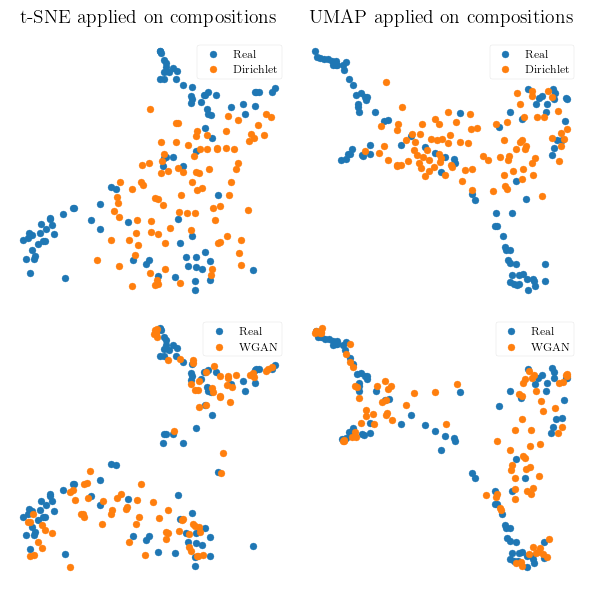

In [34]:
def dim_reduction_plots(*projections):

    def scatter(samples, ax, model, set_title=False):
        ax.scatter(samples["truth"][:, 0], samples["truth"][:, 1], s=25, label="Real")
        ax.scatter(samples[model]["data"][:, 0], samples[model]["data"][:, 1], s=25, label=samples[model]["name"])
        ax.legend(prop={"size": 8})
        if set_title:
            ax.set_title(f"{projection['method']} applied on compositions")
        ax.set_axis_off()

    f, axs = plt.subplots(2, 2, figsize=(6, 6))

    for i, projection in enumerate(projections):
        gen_datasets = [p for p in projection["samples"] if p != "truth"]
        for j, model in enumerate(gen_datasets):
            scatter(projection["samples"], axs[j, i], model, set_title=j == 0)

    f.tight_layout()
    # img_filepath = os.path.join("synthetic_data", "dimensionality_reduction_samples.png")
    # f.savefig(img_filepath, dpi=600)


projections = [
    {
        "samples": {
            "truth": tsne_truth,
            "dirichlet": {"data": tsne_dirichlet, "name": "Dirichlet"},
            "wgan": {"data": tsne_wgan, "name": "WGAN"},
        },
        "method": "t-SNE",
    },
    {
        "samples": {
            "truth": umap_truth,
            "dirichlet": {"data": umap_dirichlet, "name": "Dirichlet"},
            "wgan": {"data": umap_wgan, "name": "WGAN"},
        },
        "method": "UMAP",
    },
]
dim_reduction_plots(*projections)

DKL(truth|dirichlet) = 8.377060543737556
DKL(truth|wgan) = 5.011299613288121


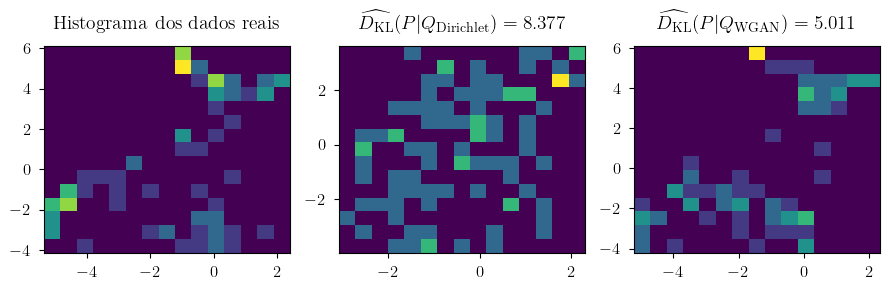

In [33]:
# 1. t-SNE on data 24dim -> 2dim
# 2. Histogram 2dim
# 3. KL divergence estimation on histogram

def normalized_histogram(data, bins):
    H, xedges, yedges = np.histogram2d(
        data[:, 0],
        data[:, 1],
        bins=bins,
        density=True,
    )
    xdelta = np.asarray([xedges[i + 1] - xedges[i] for i in range(H.shape[0])]).reshape(1, -1)
    ydelta = np.asarray([yedges[i + 1] - yedges[i] for i in range(H.shape[1])]).reshape(-1, 1)
    return H * xdelta * ydelta, xedges, yedges


def kl_divergence(p: np.ndarray, q: np.ndarray):
    eps = 0.000001
    p_mod, q_mod = p.copy(), q.copy()
    p_mod += eps
    q_mod += eps
    return rel_entr(p_mod, q_mod)


truth_reduced = tsne_truth.copy()
dirichlet_reduced = tsne_dirichlet.copy()
wgan_reduced = tsne_wgan.copy()

# Freedman-Diaconis Estimator
from scipy import stats

xwidth = 2 * stats.iqr(truth_reduced[:, 0]) / truth_reduced[:, 0].shape[0]
ywidth = 2 * stats.iqr(truth_reduced[:, 1]) / truth_reduced[:, 1].shape[0]

# Arbitrary bins counts
bins = 15

H_truth,xedges,yedges = normalized_histogram(truth_reduced, bins=bins)
H_dirichlet, _, _ = normalized_histogram(dirichlet_reduced, bins=[xedges, yedges])
H_wgan, _, _ = normalized_histogram(wgan_reduced, bins=[xedges, yedges])

kl_truth_dirichlet = kl_divergence(H_truth, H_dirichlet).sum()
kl_truth_wgan = kl_divergence(H_truth, H_wgan).sum()
print(f"DKL(truth|dirichlet) = {kl_truth_dirichlet:.4f}")
print(f"DKL(truth|wgan) = {kl_truth_wgan:.4f}")

f, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True, xshare=True)
axs[0].hist2d(truth_reduced[:, 0], truth_reduced[:, 1], bins=bins)
axs[0].set_title("Histograma dos dados reais")

axs[1].hist2d(dirichlet_reduced[:, 0], dirichlet_reduced[:, 1], bins=bins)
axs[1].set_title(r"$\widehat{D_{\mathrm{KL}}}(P|Q_{{\mathrm{Dirichlet}}}) = " + f"{kl_truth_dirichlet:.3f}" + "$")

axs[2].hist2d(wgan_reduced[:, 0], wgan_reduced[:, 1], bins=bins)
axs[2].set_title(r"$\widehat{D_{\mathrm{KL}}}(P|Q_{{\mathrm{WGAN}}}) = " + f"{kl_truth_wgan:.3f}" + "$")

plt.show()